In [2]:
!pip install opencv-contrib-python
!pip install opencv-python

In [3]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [5]:
data_dir = os.path.join(path, 'raw-img')
data_dir

'/kaggle/input/animals10/raw-img'

In [7]:
img_size = (224, 224)
batch_size = 8

In [8]:
print(type(data_dir))

<class 'str'>


cavallo
/kaggle/input/animals10/raw-img/cavallo/OIP-mdvOxIWAyReAoEJcMk5z4wHaJ4.jpeg
<class 'numpy.ndarray'>


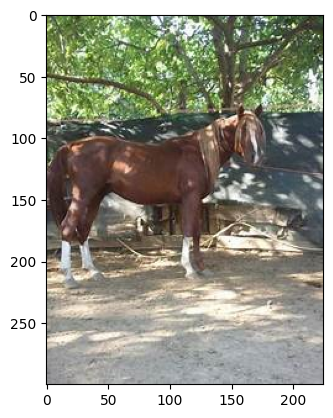

In [9]:
for name in os.listdir(data_dir):
    print(name)
    image_folder = os.path.join(data_dir, name)
    for pic_sample in os.listdir(image_folder):
        pic_path = os.path.join(image_folder, pic_sample)
        print(pic_path)
        pic_test = cv2.imread(pic_path)
        print(type(pic_test))
        pic_test = cv2.cvtColor(pic_test, cv2.COLOR_BGR2RGB)
        plt.imshow(pic_test)
        break
    break

In [12]:
X = []
y = []

In [10]:
def normalization(pic_test):
    mn = 0
    mx = 1
    norm_type = cv2.NORM_MINMAX
    b, g, r = cv2.split(pic_test)
    b_normalized = cv2.normalize(b.astype(np.float32), None, mn, mx, norm_type)
    g_normalized = cv2.normalize(g.astype(np.float32), None, mn, mx, norm_type)
    r_normalized = cv2.normalize(r.astype(np.float32), None, mn, mx, norm_type)
    
    normalized_image = cv2.merge((b_normalized, g_normalized, r_normalized))
    #normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
    return normalized_image

In [13]:
for name in os.listdir(data_dir):
    print(name) # cavallo
    image_folder = os.path.join(data_dir, name)
    for pic_sample in os.listdir(image_folder):
        pic_path = os.path.join(image_folder, pic_sample)
        # print(pic_path) #/kaggle/input/animals10/raw-img/cavallo/OIP-mdvOxIWAyReAoEJcMk5z4wHaJ4.jpeg
        pic_test = cv2.imread(pic_path)
        pic_test = cv2.resize(pic_test, img_size)
        pic_test = normalization(pic_test)
        # print(pic_test)
        # print(pic_test.shape)
        X.append(pic_test)
        y.append(name)
        # print(type(pic_test)) # np.array
        # pic_test = cv2.cvtColor(pic_test, cv2.COLOR_BGR2RGB)
        # plt.imshow(pic_test)
     

cavallo
pecora
elefante
gatto
scoiattolo
gallina
ragno
mucca
cane
farfalla


In [15]:
from sklearn.model_selection import train_test_split  # Fix import

# Assuming X and Y are properly defined dataset features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, train_size=0.1, random_state=42)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.5, train_size=0.5, random_state=42)

print("Training Set:", len(X_train))
print("Validation Set:", len(X_cv))
print("Test Set:", len(X_test))


Training Set: 1308
Validation Set: 1309
Test Set: 23562


In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert X datasets to NumPy arrays
X_train = np.array(X_train, dtype=np.float32)
X_cv = np.array(X_cv, dtype=np.float32)
# X_test = np.array(X_test, dtype=np.float32)

# Convert animal names (strings) to integer labels
label_encoder = LabelEncoder()
y_train_labels = label_encoder.fit_transform(y_train)  # Convert to integer labels
y_cv_labels = label_encoder.transform(y_cv)
# y_test_labels = label_encoder.transform(y_test)

# Apply one-hot encoding
num_classes = len(label_encoder.classes_)  # Number of unique classes
y_train = to_categorical(y_train_labels, num_classes=num_classes)
y_cv = to_categorical(y_cv_labels, num_classes=num_classes)
# y_test = to_categorical(y_test_labels, num_classes=num_classes)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_cv shape: {X_cv.shape}, y_cv shape: {y_cv.shape}")

# Optional: Print class mapping
print("Class mapping:", dict(enumerate(label_encoder.classes_)))


X_train shape: (1308, 224, 224, 3), y_train shape: (1308, 10)
X_cv shape: (1309, 224, 224, 3), y_cv shape: (1309, 10)
Class mapping: {0: 'cane', 1: 'cavallo', 2: 'elefante', 3: 'farfalla', 4: 'gallina', 5: 'gatto', 6: 'mucca', 7: 'pecora', 8: 'ragno', 9: 'scoiattolo'}


In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
base_model.trainable = False

model = Sequential([base_model, 
                   Flatten(), 
                   Dense(256, activation='relu'),
                   Dropout(0.5),
                   Dense(10, activation = 'softmax')])

model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

checkpoint = ModelCheckpoint('best_model2.keras',
                            monitor = 'val_loss', 
                            save_best_only = True,
                            mode = 'min',
                            verbose = 1)

history = model.fit(
    X_train, y_train, epochs = 10, validation_data = (X_cv, y_cv), 
    batch_size = 1,
    callbacks=[checkpoint]
)

Epoch 1/10
1305/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3168 - loss: 2.1791
Epoch 1: val_loss improved from inf to 1.16333, saving model to best_model2.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.3171 - loss: 2.1779 - val_accuracy: 0.5867 - val_loss: 1.1633
Epoch 2/10
1307/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6433 - loss: 1.0617
Epoch 2: val_loss improved from 1.16333 to 1.01214, saving model to best_model2.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.6432 - loss: 1.0617 - val_accuracy: 0.6501 - val_loss: 1.0121
Epoch 3/10
1304/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7051 - loss: 0.8433
Epoch 3: val_loss improved from 1.01214 to 0.90816, saving model to best_model2.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.7052 - loss: 0.8431 - val_accuracy: 0.6845 - val_loss: 0.9082
Epoch 4/10
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8117 - loss: 0.5765
Epoch 4: val_loss improved 